# ネットワークの構築

## 3.1 神经元之间的连接

### 3.1.1 Full Connection

In [16]:
class FullConnection:
    def __init__(self, N_in, N_out, initW=None):
        if initW is not None:
            self.W = initW
        else:
            self.W = 0.1 * np.random.rand(N_out, N_in)

    def backward(self, x):
        return np.dot(self.W.T, x) #self.W.T @ x

    def __call__(self, x):
        return np.dot(self.W, x) #self.W @ x

### 3.1.2 Convolution2D connection

全连接与2维卷积均与ANN相同

### 3.1.3 Delay connection

实际上对于神经元，在发火后并不是瞬间传递到突触后细胞。存在由**轴索延迟(axonal delays)**造成的**突触延迟(synaptic delay)**

下列的代码:

+ 实现与模拟通常的离散延迟微分方程式相同。
  
+ 准备行数为神经元数，列数与延迟时间的模拟步数相同长度的矩阵。

+ 每一步输出最后一行的向量，错开数组后，用新输入更新第一行。

In [11]:
class DelayConnection:
    def __init__(self, N, delay, dt=1e-4):
        nt_delay = round(delay/dt) # 遅延のステップ数
        self.state = np.zeros((N, nt_delay))
    
    def __call__(self, x):
        out = self.state[:, -1] # 出力
        self.state[:, 1:] = self.state[:, :-1] # 配列をずらす
        self.state[:, 0] = x # 入力
        return out

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\Micro\AppData\Local\Temp\ipykernel_176\808768334.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v_arr1[t] = neuron1.v_
C:\Users\Micro\AppData\Local\Temp\ipykernel_176\808768334.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v_arr2[t] = neuron2.v_
100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 12633.60it/s]


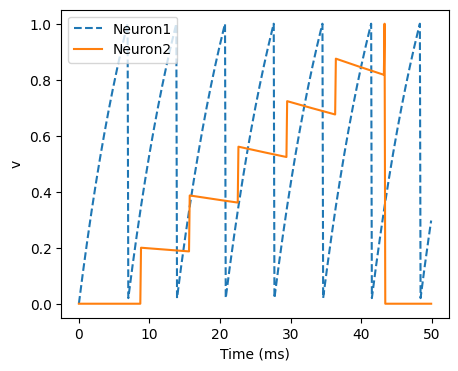

In [18]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from Models.Neurons import CurrentBasedLIF
from Models.Connections import DelayConnection

dt = 1e-4; T = 5e-2; nt = round(T/dt)
#モデルの定義
neuron1 = CurrentBasedLIF(N=1, dt=dt, tc_m=1e-2, tref=0,
vrest=0, vreset=0, vthr=1, vpeak=1)
neuron2 = CurrentBasedLIF(N=1, dt=dt, tc_m=1e-1, tref=0,
vrest=0, vreset=0, vthr=1, vpeak=1)
delay_connect = DelayConnection(N=1, delay=2e-3, dt=dt)
I = 2 # 入力電流
v_arr1 = np.zeros(nt); v_arr2 = np.zeros(nt) #記録用配列

for t in tqdm(range(nt)):
    # 更新
    s1 = neuron1(I)
    #print(s1)
    d1 = delay_connect(s1)
    s2 = neuron2(0.02/dt*d1)
    # 保存
    v_arr1[t] = neuron1.v_
    v_arr2[t] = neuron2.v_

time = np.arange(nt)*dt*1e3
plt.figure(figsize=(5, 4))
plt.plot(time, v_arr1, label="Neuron1", linestyle="dashed")
plt.plot(time, v_arr2, label="Neuron2")
plt.xlabel("Time (ms)"); plt.ylabel("v")
plt.legend(loc="upper left")
plt.show()

上图为从神经元1到神经元2存在2ms延迟发火的情况。

## 3.2 Random Network

本节使用实现的元素构建权重随机的SNN。

网络存在2层。

+ 第1层存在10个Poisson Neuron。

+ 第2层假设存在1给LIF Neuron。

+ 第1层到第2层的结合使用二重指数函数型突触。


+ **目标**： 表现第2层的神经元膜电位以及输入电流以及第一层神经元的使用raster plot(发火时间点图).


In [19]:
from Models.Neurons import CurrentBasedLIF
from Models.Synapses import DoubleExponentialSynapse

np.random.seed(seed=0)


dt = 1e-4; T = 1; nt = round(T/dt) # Simulation time
num_in = 10; num_out = 1 # input/output neuron amount

# input possion spike
fr_in = 30 # input possion spike発火率 (Hz)
x = np.where(np.random.rand(nt, num_in) < fr_in * dt, 1, 0) # generate spike

W = 0.2*np.random.randn(num_out, num_in) # random connection weight

# model
# output size, time delta, efactory time period (s), membrance time constance, Static membrane potential, reset potential, potential threashold, peak potential
neurons = CurrentBasedLIF(N=num_out, dt=dt, tref=5e-3, tc_m=1e-2, vrest=-65, vreset=-60, vthr=-40, vpeak=30)

synapses = DoubleExponentialSynapse(N=num_out, dt=dt, td=1e-2, tr=1e-2)
# 記録用配列
current = np.zeros((num_out, nt))
voltage = np.zeros((num_out, nt))


In [26]:
# Simulation
neurons.initialize_states() # init states
for t in tqdm(range(nt)):
    # update
    I = synapses(np.dot(W, x[t]))
    s = neurons(I)
    # record
    current[:, t] = I
    voltage[:, t] = neurons.v_

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 29449.87it/s]


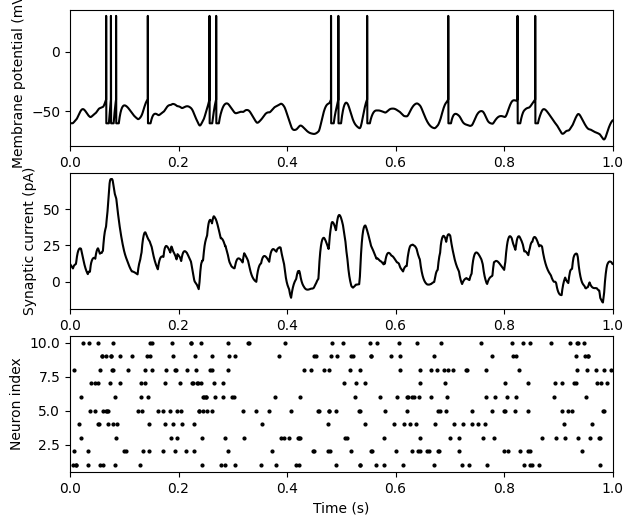

In [27]:
# 結果表示
t = np.arange(nt)*dt
plt.figure(figsize=(7, 6))

plt.subplot(3,1,1)
plt.plot(t, voltage[0], color="k")
plt.xlim(0, T)
plt.ylabel('Membrane potential (mV)')

plt.subplot(3,1,2)
plt.plot(t, current[0], color="k")
plt.xlim(0, T)
plt.ylabel('Synaptic current (pA)')

plt.subplot(3,1,3)
for i in range(num_in):
    plt.plot(t, x[:, i] * (i+1), 'ko', markersize=2)
plt.xlabel('Time (s)')
plt.ylabel('Neuron index')
plt.xlim(0, T)
plt.ylim(0.5, num_in+0.5)
plt.show()

## 3.3 SNN训练

SNN是省电的。理由：

+ 神经元的输出仅有0/1。可用使用低电量的converter

+ 仅spike到达时驱动AI芯片。(event-driven)。不需要同期lock。可以非同期地动作。



训练的5方针：

1. ANN 2值化

2. ANN转换为SNN

3. **constrain-then-train**: 带有条件限制的ANN->SNN转换

+ 有一个叫做Noisy Softplus的ANN激活函数的建议

$$y = f_{ns}(x,\sigma)=k\sigma\;log[1+exp(\frac{x}{k\sigma})]$$

1. 近似反向传播学习的的监督式学习

2. 由局部学习规则进行的无监督学习
+ e.g., STDP (spike-timing dependent plasticity) 

1. 二值化方法参照: (Hubara et al., 2016; Kim & Smaragdis, 2016; Rastegari et al., 2016; Severa et al., 2019) , etc.

2. ANN -> SNN 変換参照 (Sengupta et al., 2019) etc

3. 参照  (Esser et al., 2015) 